In [19]:
# version 2.1.2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import solve_ivp

def _generate_points(u0_start, s0_start, alpha, beta, gamma, t1, t2, samples):

    def trans_dynamics(t, expr): 
        s = expr[0]
        u = expr[1]
        du_dt = alpha - beta*u
        ds_dt = beta*u - gamma*s
        return [ds_dt, du_dt]

    t_space = np.linspace(t1, t2, samples)

    num_sol = solve_ivp(
            trans_dynamics, 
            [0, t2], 
            [s0_start, u0_start], 
            method='RK45', 
            dense_output=True)

    XY_num_sol = num_sol.sol(t_space)
    S, U = XY_num_sol[0], XY_num_sol[1]
    return U, S

def _jitter(U, S, scale):
    S = S + np.random.normal(
            loc=0.0, 
            scale=scale*np.percentile(S, 99) / 10, 
            size=np.size(S))
    U = U + np.random.normal(
            loc=0.0, 
            scale=scale*np.percentile(U, 99) / 10, 
            size=np.size(U))

    S1 = S[(S>0)&(U>0)]
    U1 = U[(S>0)&(U>0)]
    S1, U1 = np.clip(S, 0, None), np.clip(U, 0, None)
    return U1, S1

def _simulate(u0_start, s0_start, alpha, beta, gamma, t1, t2, samples, dt=0.001):
    u0, s0 = _generate_points(
            u0_start, 
            s0_start, 
            alpha, 
            beta, 
            gamma, 
            t1, 
            t2, 
            samples)
    u0_end, s0_end = u0[-1], s0[-1]
    #u0, s0 = _jitter(u0, s0, scale)
    u1 = u0 + (alpha - beta*u0)*dt
    s1 = s0 + (beta*u0 - gamma*s0)*dt

    expr = pd.DataFrame(u0, columns=['u0'])
    expr['s0'] = s0
    expr['u1'] = u1
    expr['s1'] = s1
    expr['alpha'] = alpha
    expr['beta'] = beta
    expr['gamma'] = gamma
    return expr, (u0_end, s0_end)

def _simulate_without_t(
        u0_start, 
        s0_start, 
        alpha, 
        beta, 
        gamma, 
        percent_start_u, 
        percent_end_u, 
        samples, 
        dt=0.001):
    '''percentage_u: u_end/u_max'''

    def inversed_u(u, expr): 
        t = expr[0]
        dt_du = 1/(alpha - beta*u)
        return dt_du

    if alpha != 0:
        u_max = alpha/beta
        u_start = u0_start + (u_max-u0_start) * percent_start_u/100
        u_end = u0_start + (u_max-u0_start)  * percent_end_u/100
    else:
        u_max = u0_start
        u_start = u_max * (100-percent_start_u)/100
        u_end = u_max * (100-percent_end_u)/100

    t_sol = solve_ivp(
            inversed_u, 
            [u0_start, u_end], 
            [0], 
            method='RK45', 
            dense_output=True)
    t1 = t_sol.sol(u_start)[0]  
    t2 = t_sol.sol(u_end)[0]  

    expr, (last_u, last_s) = _simulate(
            u0_start, s0_start, 
            alpha, beta, gamma, 
            t1, t2, samples, dt)
    return expr, (last_u, last_s), (t1, t2)

def generate_with_df(gene_info, dt=0.001, noise_level=0.2):
    expr = pd.DataFrame()
    last_u, last_s = None, None
    t1, t2 = None, None

    gene_info['t1'] = None
    gene_info['t2'] = None
    for i in range(len(gene_info.index)):
        gene_name, start_u, start_s = gene_info['gene_name'][i], gene_info['start_u'][i], gene_info['start_s'][i]
        alpha, beta, gamma = gene_info['alpha'][i], gene_info['beta'][i], gene_info['gamma'][i]
        start_pct, end_pct, samples = gene_info['start_pct'][i], gene_info['end_pct'][i], gene_info['samples'][i]
        if start_u is not None and start_s is not None:
            expr_tmp, (last_u, last_s), (t1, t2) = _simulate_without_t(start_u, start_s, alpha, beta, gamma, start_pct, end_pct, samples)
            gene_info['t1'][i] = t1
            gene_info['t2'][i] = t2
        else:
            if last_u is None or last_s is None:
                print("start_u and start_s should not be None at the first line.")
                return None
            expr_tmp, (last_u, last_s), (t1, t2) = _simulate_without_t(last_u, last_s, alpha, beta, gamma, start_pct, end_pct, samples)
            gene_info['t1'][i] = t1
            gene_info['t2'][i] = t2
        expr = expr.append(expr_tmp)
    expr.index = range(len(expr))
    #expr.u0, expr.s0 = _jitter(expr.u0, expr.s0, noise_level)
    return gene_info, expr

def generate_2circle():
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':15, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':0, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':25, 'beta':10, 'gamma':10, 'start_pct':0, 'end_pct':70, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':0, 'beta':10, 'gamma':10, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
 
    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c=expr['alpha'], s=1)
    plt.show()

def generate_2backward():
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':1, 'start_s':2, 'alpha':0, 'beta':10, 'gamma':10, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':2, 'start_s':1.5, 'alpha':0, 'beta':10, 'gamma':10, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)

    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c=expr['alpha'], s=1)
    plt.show()

def generate_2backward2():
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':1.5, 'start_s':1.2, 'alpha':0, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':1.5, 'start_s':1.2, 'alpha':0, 'beta':15, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)

    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c=expr['beta'], s=1)
    plt.show()

def generate_by_each_cell(df, t, dt=0.001, normal_scale=0):
    expr = pd.DataFrame()
    ti = t/(len(df.index)-1)

    #the first point
    expr, (last_u0, last_s0) = _simulate(
        u0_start = 0, s0_start=0, 
        alpha=df['alpha'][0], beta=df['beta'][0], gamma=df['gamma'][0], 
        t1=0, t2=ti, #If samples=1, t2 value doesn't matter, because only one point will be generated
        samples=1, 
        dt=dt)

    for i in range(1, len(df.index)):
        sub_expr, (u0i, s0i) = _simulate(
            u0_start = last_u0, s0_start=last_s0, 
            alpha=df['alpha'][i], beta=df['beta'][i], gamma=df['gamma'][i], 
            t1=ti, t2=ti, #If samples=1, t2 value doesn't matter, because only one point will be generated
            samples=1, 
            dt=dt)

        last_u0, last_s0 = u0i, s0i
        expr = expr.append(sub_expr)

    if normal_scale != 0:
        expr.u0, expr.s0 = _jitter(expr.u0, expr.s0, normal_scale)
 
    expr.index = range(len(expr.index))
    expr['t'] = ti * (expr.index+1)
    return expr

def generate_by_each_cell_poisson(df, t, poisson_scale=1000, dt=0.001, normal_scale=0):
    ''' deprecated. use poisson distribution
    '''
    expr = pd.DataFrame()
    ti = t/(len(df.index)-1)

    #the first point
    expr, (last_u0, last_s0) = _simulate(
        u0_start = df['u0'][0], s0_start=df['s0'][0], 
        alpha=df['alpha'][0], beta=df['beta'][0], gamma=df['gamma'][0], 
        t1=0, t2=ti, #If samples=1, t2 value doesn't matter, because only one point will be generated, whitch is returned (last_u0, last_s0)
        samples=1, 
        dt=dt)

    for i in range(1, len(df.index)):
        #last_u0 = np.random.poisson(last_u0*scale, 1000)[np.random.randint(0, 999)] / scale
        #last_s0 = np.random.poisson(last_s0*scale, 1000)[np.random.randint(0, 999)] / scale
        last_u0 = np.random.poisson(last_u0*poisson_scale, 1)[0] / poisson_scale
        last_s0 = np.random.poisson(last_s0*poisson_scale, 1)[0] / poisson_scale
        sub_expr, (u0i, s0i) = _simulate(
            u0_start = last_u0, s0_start=last_s0, 
            alpha=df['alpha'][i], beta=df['beta'][i], gamma=df['gamma'][i], 
            t1=ti, t2=ti, #If samples=1, t2 value doesn't matter, because only one point will be generated, whitch is returned (u0i, s0i)
            samples=1, 
            dt=dt)

        last_u0, last_s0 = u0i, s0i
        expr = expr.append(sub_expr)

    if normal_scale != 0:
        expr.u0, expr.s0 = _jitter(expr.u0, expr.s0, normal_scale)

    expr.index = range(len(expr.index))
    expr['t'] = ti * (expr.index+1)
    return expr

def generate_by_each_cell_normal(df, t, rw_scale=0, rw_basic=0, dt=0.001, normal_scale=0, times=1):
    expr = pd.DataFrame()
    ti = t/(len(df.index)-1)

    for i in range(times):
    #the first point
        sub_expr, (last_u0, last_s0) = _simulate(
            u0_start = df['u0'][0], s0_start=df['s0'][0], 
            alpha=df['alpha'][0], beta=df['beta'][0], gamma=df['gamma'][0], 
            t1=0, t2=ti, #If samples=1, t2 value doesn't matter, because only one point will be generated, whitch is returned (last_u0, last_s0)
            samples=1, 
            dt=dt)
        expr = expr.append(sub_expr)

        for i in range(1, len(df.index)):
            last_u0 = np.random.normal(last_u0, last_u0*rw_scale+rw_basic)
            last_s0 = np.random.normal(last_s0, last_s0*rw_scale+rw_basic)
            sub_expr, (u0i, s0i) = _simulate(
                u0_start = last_u0, s0_start=last_s0, 
                alpha=df['alpha'][i], beta=df['beta'][i], gamma=df['gamma'][i], 
                t1=ti, t2=ti, #If samples=1, t2 value doesn't matter, because only one point will be generated, whitch is returned (u0i, s0i)
                samples=1, 
                dt=dt)

            last_u0, last_s0 = u0i, s0i
            expr = expr.append(sub_expr)

    if normal_scale != 0:
        expr.u0, expr.s0 = _jitter(expr.u0, expr.s0, normal_scale)

    expr.index = range(len(expr.index))
    expr['t'] = ti * (expr.index+1)
    return expr

def generate_by_each_cell_randomwalk(df, t, rw_scale=0, dt=0.001, normal_scale=0):
    ''' deprecated. use random every step
    '''
    expr = pd.DataFrame()
    ti = t/(len(df.index)-1)

    #the first point
    expr, (last_u0, last_s0) = _simulate(
        u0_start = df['u0'][0], s0_start=df['s0'][0], 
        alpha=df['alpha'][0], beta=df['beta'][0], gamma=df['gamma'][0], 
        t1=0, t2=ti, #If samples=1, t2 value doesn't matter, because only one point will be generated, whitch is returned (last_u0, last_s0)
        samples=1, 
        dt=dt)
    last_du, last_ds = 0, 0

    for i in range(1, len(df.index)):
        #print("last_u0_0:", last_u0)
        if rw_scale != 0:
            jittered_du = np.random.normal(loc=0.0, scale=abs(last_du)*rw_scale)
            jittered_ds = np.random.normal(loc=0.0, scale=abs(last_ds)*rw_scale)
            last_u0 = last_u0 + jittered_du
            last_s0 = last_s0 + jittered_ds
        sub_expr, (u0i, s0i) = _simulate(
            u0_start = last_u0, s0_start=last_s0, 
            alpha=df['alpha'][i], beta=df['beta'][i], gamma=df['gamma'][i], 
            t1=ti, t2=ti, #If samples=1, t2 value doesn't matter, because only one point will be generated, whitch is returned (u0i, s0i)
            samples=1, 
            dt=dt)
        
        last_du, last_ds = u0i - last_u0, s0i - last_s0
        last_u0, last_s0 = u0i, s0i
        expr = expr.append(sub_expr)

    if normal_scale != 0:
        expr.u0, expr.s0 = _jitter(expr.u0, expr.s0, normal_scale)

    expr.index = range(len(expr.index))
    expr['t'] = ti * (expr.index+1)
    return expr

def test_poisson():
    ##############################################
    #random walk with poisson distribution test
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':15, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':0, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c='red', s=10)
    #plt.show()
    data_cell = generate_by_each_cell(expr, t=gene_info['t2'].sum())
    plt.scatter(data_cell['s0'], data_cell['u0'], c='blue', s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()
    data_cell = generate_by_each_cell_poisson(expr, poisson_scale=10000, t=gene_info['t2'].sum())
    plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()
    #relationship between t and alpha
    plt.scatter(data_cell.t, data_cell.alpha,  s=1)
    plt.xlabel("t")
    plt.ylabel("alpha")
    plt.show()
    #relationship between t and beta
    plt.scatter(data_cell.t, data_cell.beta, s=1)
    plt.xlabel("t")
    plt.ylabel("beta")
    plt.show()
    #relationship between t and gamma
    plt.scatter(data_cell.t, data_cell.gamma, s=1)
    plt.xlabel("t")
    plt.ylabel("gamma")
    plt.show()

    #########################################
    #random walk  with poisson distribution in different situations

    #circle
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':15, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':0, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c='red', s=10)
    plt.show()
    data_cell = generate_by_each_cell_poisson(expr, poisson_scale=10000, t=gene_info['t2'].sum())
    plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()

    #accerate
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':10, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':500}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':20, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':500}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    #int(2000/gene_info['t2'].sum()*gene_info['t2'][0])
    #2000-int(2000/gene_info['t2'].sum()*gene_info['t2'][0])
    plt.scatter(expr['s0'], expr['u0'], c='red', s=10)
    plt.show()
    data_cell = generate_by_each_cell_poisson(expr, poisson_scale=100, t=gene_info['t2'].sum())
    plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':10, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':500}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':20, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':500}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    #int(2000/gene_info['t2'].sum()*gene_info['t2'][0])
    #2000-int(2000/gene_info['t2'].sum()*gene_info['t2'][0])
    data_cell = generate_by_each_cell_poisson(expr, poisson_scale=1000, t=gene_info['t2'].sum())
    plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':10, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':500}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':20, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':500}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    #int(2000/gene_info['t2'].sum()*gene_info['t2'][0])
    #2000-int(2000/gene_info['t2'].sum()*gene_info['t2'][0])
    data_cell = generate_by_each_cell_poisson(expr, poisson_scale=10000, t=gene_info['t2'].sum())
    plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':10, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':500}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':20, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':500}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    #int(2000/gene_info['t2'].sum()*gene_info['t2'][0])
    #2000-int(2000/gene_info['t2'].sum()*gene_info['t2'][0])
    data_cell = generate_by_each_cell_poisson(expr, poisson_scale=100000, t=gene_info['t2'].sum())
    plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()


    #degrade
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':1.5, 'start_s':1.2, 'alpha':0, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c='red', s=10)
    plt.show()
    data_cell = generate_by_each_cell_poisson(expr, poisson_scale=10000, t=gene_info['t2'].sum())
    plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()

def test_randomwalk():
    '''test generate_by_each_cell_randomwalk()'''
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':15, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':0, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    data_cell = generate_by_each_cell_randomwalk(expr, rw_scale=5, t=gene_info['t2'].sum())
    plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()

    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':15, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':100}, ignore_index=True)
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':None, 'start_s':None, 'alpha':0, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':100}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    data_cell = generate_by_each_cell_randomwalk(expr, rw_scale=1, t=gene_info['t2'].sum())
    plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()    

def test_solve_ivp():
    ##############################################
    ###### difference between only-one solve_ivp and sectional solve_ivp
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':15, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':10}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c='red', s=10)
    #plt.show()
    data_cell = generate_by_each_cell(expr, t=gene_info['t2'][0])
    plt.scatter(data_cell['s0'], data_cell['u0'], c='blue', s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':15, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':100}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c='red', s=10)
    #plt.show()
    data_cell = generate_by_each_cell(expr, t=gene_info['t2'][0])
    plt.scatter(data_cell['s0'], data_cell['u0'], c='blue', s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()
    gene_info = pd.DataFrame(columns = ['gene_name', 'start_u', 'start_s', 'alpha', 'beta', 'gamma', 'start_pct', 'end_pct', 'samples'])
    gene_info = gene_info.append({'gene_name':'g1', 'start_u':0, 'start_s':0, 'alpha':15, 'beta':10, 'gamma':12, 'start_pct':0, 'end_pct':99, 'samples':1000}, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    plt.scatter(expr['s0'], expr['u0'], c='red', s=10)
    #plt.show()
    data_cell = generate_by_each_cell(expr, t=gene_info['t2'][0])
    plt.scatter(data_cell['s0'], data_cell['u0'], c='blue', s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()

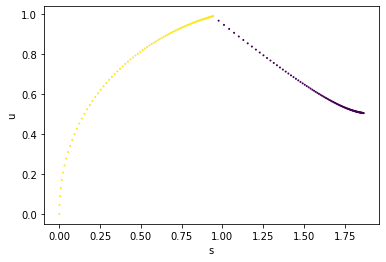

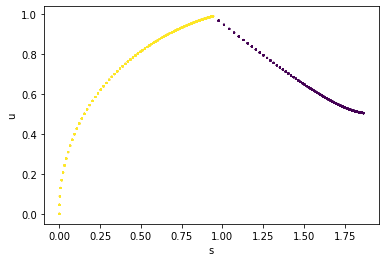

In [22]:
if __name__ == "__main__":
    import sys
    sys.path.append('.')
#    from utilities import set_rcParams
#    set_rcParams()

    #########################################
    #random walk. Normal distribution in each steps

    # Circle

    columns = ['gene_name', 
            'start_u', 'start_s', 
            'alpha', 'beta', 'gamma', 
            'start_pct', 'end_pct', 
            'samples']

    upper = {'gene_name':'g1', 
            'start_u':0, 'start_s':0, 
            'alpha':15, 'beta':10, 'gamma':12, 
            'start_pct':0, 'end_pct':99, 
            'samples':1000}

    lower = {'gene_name':'g1', 
            'start_u':None, 'start_s':None, 
            'alpha':0, 'beta':10, 'gamma':12, 
            'start_pct':0, 'end_pct':99, 
            'samples':1000}
    #
#     gene_info = pd.DataFrame(columns = columns)
#     gene_info = gene_info.append(upper, ignore_index=True)
#     gene_info = gene_info.append(lower, ignore_index=True)
#     gene_info, expr = generate_with_df(gene_info)
#     data_cell = generate_by_each_cell_normal(
#             expr, 
#             # rw_scale=0.01, 
#             # rw_basic=0.002, 
#             t=gene_info['t2'].sum())

#     plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
#     plt.xlabel("s")
#     plt.ylabel("u")
#     plt.show()
#     ## Overlapped randomwalk
#     data_cell = generate_by_each_cell_normal(
#            expr, 
#            rw_scale=0.01, 
#            rw_basic=0.002,  
#            t=gene_info['t2'].sum(), 
#            times=20)
#     plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
#     plt.xlabel("s")
#     plt.ylabel("u")
#     plt.show()

    # multipath
    
    columns = ['gene_name', 
            'start_u', 'start_s', 
            'alpha', 'beta', 'gamma', 
            'start_pct', 'end_pct', 
            'samples']

    upper = {'gene_name':'g1', 
            'start_u':0, 'start_s':0, 
            'alpha':1, 'beta':1, 'gamma':1, 
            'start_pct':0, 'end_pct':99, 
            'samples':100}

    lower = {'gene_name':'g1', 
            'start_u':0, 'start_s':0, 
            'alpha':0.5, 'beta':1, 'gamma':0.25, 
            'start_pct':0, 'end_pct':99, 
            'samples':100}
    gene_info = pd.DataFrame(columns = columns)
    gene_info = gene_info.append(upper, ignore_index=True)
    gene_info = gene_info.append(lower, ignore_index=True)
    gene_info, expr = generate_with_df(gene_info)
    data_cell = generate_by_each_cell_normal(
            expr, 
            # rw_scale=0.01, 
            # rw_basic=0.002, 
            t=gene_info['t2'].sum())

    plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()
    ## Overlapped randomwalk
    data_cell = generate_by_each_cell_normal(
           expr, 
           # rw_scale=0.01, 
           # rw_basic=0.002,  
           t=gene_info['t2'].sum(), 
           times=20)
    plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
    plt.xlabel("s")
    plt.ylabel("u")
    plt.show()
    
    
#     # Accerate
#     gene_info = pd.DataFrame(columns = columns)
#     # step_1 = {'gene_name':'g1', 
#     #         'start_u':0, 'start_s':0, 
#     #         'alpha':10, 'beta':10, 'gamma':12, 
#     #         'start_pct':0, 'end_pct':99, 
#     #         'samples':500}
#     # step_2 = {'gene_name':'g1', 
#     #         'start_u':None, 'start_s':None, 
#     #         'alpha':40, 'beta':10, 'gamma':12, 
#     #         'start_pct':0, 'end_pct':99, 
#     #         'samples':500}
#     step_1 = {'gene_name':'g1', 
#             'start_u':0, 'start_s':0, 
#             'alpha':1, 'beta':1, 'gamma':1, 
#             'start_pct':0, 'end_pct':99, 
#             'samples':50}
#     step_2 = {'gene_name':'g1', 
#             'start_u':None, 'start_s':None, 
#             'alpha':2, 'beta':1, 'gamma':1, 
#             'start_pct':0, 'end_pct':99, 
#             'samples':50}
#     gene_info = gene_info.append(step_1, ignore_index=True)
#     gene_info = gene_info.append(step_2, ignore_index=True)
#     gene_info, expr = generate_with_df(gene_info)

#     data_cell = generate_by_each_cell_normal(
#             expr, 
#             # rw_scale=0.01, 
#             # rw_basic=0.002, 
#             t=gene_info['t2'].sum())

#     plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
#     plt.xlabel("s")
#     plt.ylabel("u")
#     plt.show()

#     # Degrade
#     gene_info = pd.DataFrame(columns = columns)
#     lower = {'gene_name':'g1', 
#             'start_u':1.5, 'start_s':1.2, 
#             'alpha':0, 'beta':10, 'gamma':12, 
#             'start_pct':0, 'end_pct':99, 
#             'samples':1000}
#     gene_info = gene_info.append(lower, ignore_index=True)
#     gene_info, expr = generate_with_df(gene_info)

#     data_cell = generate_by_each_cell_normal(
#             expr, 
#             # rw_scale=0.01, 
#             # rw_basic=0.002, 
#             t=gene_info['t2'].sum())

#     plt.scatter(data_cell['s0'], data_cell['u0'], c=data_cell['alpha'], s=1)
#     plt.xlabel("s")
#     plt.ylabel("u")
#     plt.show()

In [2]:
data_cell

,u0,s0,u1,s1,alpha,beta,gamma,t
0,0.000000,0.000000,0.015000,0.000000,15,10,12,0.000461
1,0.006890,-0.003719,0.021821,-0.003606,15,10,12,0.000922
2,0.015397,-0.001160,0.030243,-0.000992,15,10,12,0.001383
3,0.018409,-0.002972,0.033225,-0.002752,15,10,12,0.001844
4,0.023011,-0.003686,0.037781,-0.003412,15,10,12,0.002305
...,...,...,...,...,...,...,...,...
1995,-0.017679,0.012225,-0.017502,0.011902,0,10,12,0.920083
1996,-0.014326,0.013109,-0.014183,0.012808,0,10,12,0.920544
1997,-0.014553,0.013754,-0.014408,0.013444,0,10,12,0.921005
1998,-0.015164,0.014665,-0.015013,0.014338,0,10,12,0.921466


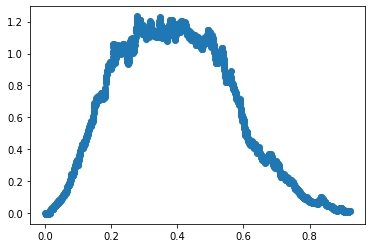

In [3]:
plt.scatter(data_cell.t,data_cell.s0)

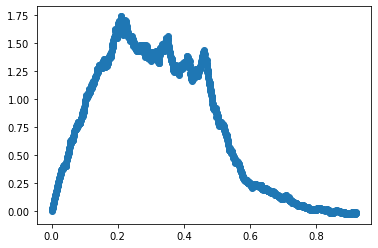

In [8]:
plt.scatter(data_cell.t,data_cell.u0)

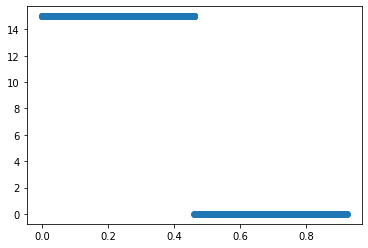

In [5]:
plt.scatter(data_cell.t,data_cell.alpha)

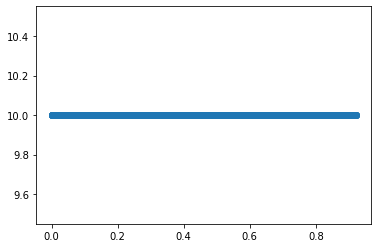

In [6]:
plt.scatter(data_cell.t,data_cell.beta)

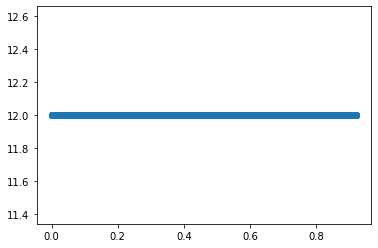

In [7]:
plt.scatter(data_cell.t,data_cell.gamma)